## Загружаем библиотеки ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_white
from statsmodels.iolib.summary2 import summary_col
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from pmdarima.arima import auto_arima
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")

## Fear and Greed Index ##

In [2]:
df_fg = pd.read_excel('Fear and Greed Index crypto.xlsx', index_col=None)
df_fg.Date = pd.to_datetime(df_fg.Date)
df_fg = df_fg.iloc[::-1]
df_fg = df_fg.set_index('Date')
df_fg.drop('Label', axis=1, inplace=True)
df_fg = df_fg.rename(columns={'Value': 'FG'})

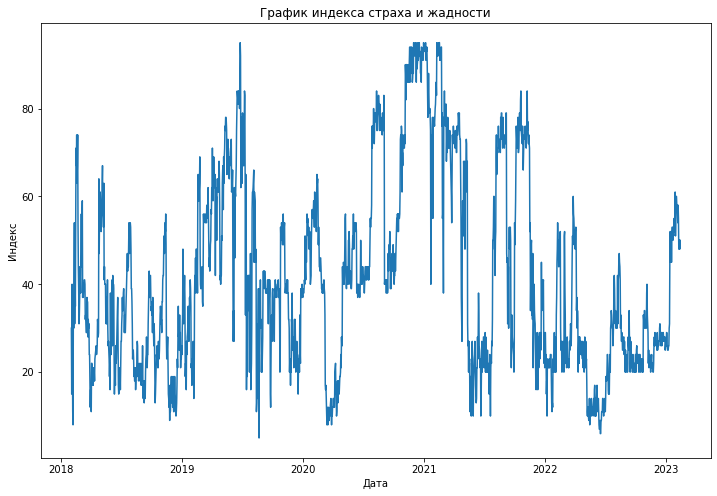

In [3]:
# Создаем график
fig, ax = plt.subplots(figsize=(12, 8))

# Строим линейный график
ax.plot(df_fg["FG"])

# Настраиваем оси и заголовок графика
ax.set_xlabel('Дата')
ax.set_ylabel('Индекс')
ax.set_title('График индекса страха и жадности')

# Показываем график
plt.show()

In [4]:
#df_fg["FG change"] = df_fg["FG"].pct_change()

#df_fg.drop("FG", axis=1, inplace=True)

df_fg["FG"] = df_fg["FG"].pct_change()

df_fg = df_fg[1:]

## TVL data  ##

In [5]:
data_tvl = pd.read_csv('chain-dataset-All.csv')

date_tvl = []
q_tvl = []

for i in range(1, len(list(data_tvl.columns))):
    a = list(data_tvl.columns)[i].split('/')
    b = a[2] + '-' + a[1] + '-' + a[0]
    date_tvl.append(b)
    c = data_tvl[list(data_tvl.columns)[i]][1]
    q_tvl.append(c)

df_tvl = pd.DataFrame({"Date": date_tvl, "TVL": q_tvl})
df_tvl.Date = pd.to_datetime(df_tvl.Date)
df_tvl = df_tvl.set_index('Date')

In [6]:
df_tvl["TVL change"] = df_tvl["TVL"].pct_change()
df_tvl.drop("TVL", axis=1, inplace=True)
df_tvl = df_tvl[1:]

df_tvl

,TVL change
Date,
2018-11-04,0.191211
2018-11-05,-0.017360
2018-11-06,0.062625
2018-11-07,2.573326
2018-11-08,0.170475
...,...
2023-01-15,0.019993
2023-01-16,0.003339
2023-01-17,0.001474


## VIX Index ##

In [7]:
df_vix = pd.read_csv('VIX_History.csv')
df_vix.DATE = pd.to_datetime(df_vix.DATE)
df_vix.drop('OPEN', axis=1, inplace=True)
df_vix.drop('HIGH', axis=1, inplace=True)
df_vix.drop('LOW', axis=1, inplace=True)
df_vix = df_vix[-1200:]
df_vix.rename(columns = {'DATE':'Date', 'CLOSE': 'VIX'}, inplace = True )
df_vix = df_vix.set_index('Date')

idx = pd.date_range(start=df_vix.index.min(), end=df_vix.index.max(), freq='D')
new_df = pd.DataFrame(index=idx)
df_vix = pd.concat([df_vix, new_df], axis=1)
df_vix = df_vix.interpolate(method='time')
df_vix['VIX'] = df_vix['VIX'].fillna(df_vix['VIX'].rolling(2, min_periods=1).mean())

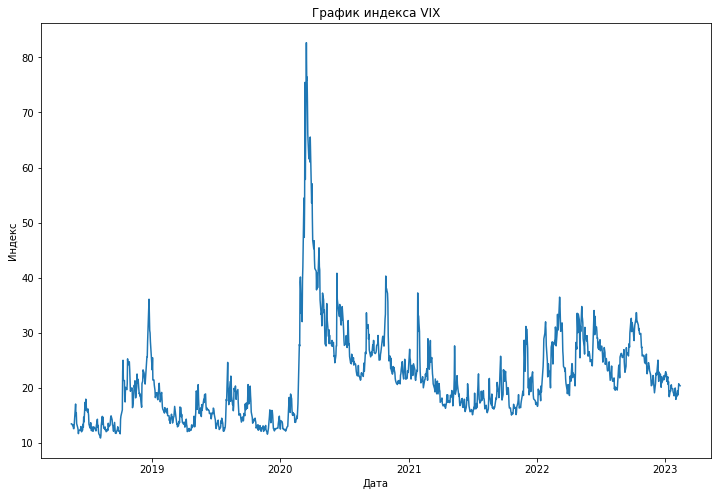

In [8]:
# Создаем график
fig, ax = plt.subplots(figsize=(12, 8))

# Строим линейный график
ax.plot(df_vix["VIX"])

# Настраиваем оси и заголовок графика
ax.set_xlabel('Дата')
ax.set_ylabel('Индекс')
ax.set_title('График индекса VIX')

# Показываем график
plt.show()

In [9]:
#df_vix["VIX change"] = df_vix["VIX"].pct_change()

#df_vix.drop("VIX", axis=1, inplace=True)

df_vix["VIX"] = df_vix["VIX"].pct_change()

df_vix = df_vix[1:]

## Trading data ##

Загружаем биржевые данные "голубых фишек".

In [10]:
data_btc = pd.read_csv('btc-usd-max.csv')
data_eth = pd.read_csv('eth-usd-max.csv')
data_bnb = pd.read_csv('bnb-usd-max.csv')
data_xrp = pd.read_csv('xrp-usd-max.csv')
data_ada = pd.read_csv('ada-usd-max.csv')
data_matic = pd.read_csv('matic-usd-max.csv')
data_sol = pd.read_csv('sol-usd-max.csv')
data_dot = pd.read_csv('dot-usd-max.csv')
data_ltc = pd.read_csv('ltc-usd-max.csv')
data_trx = pd.read_csv('trx-usd-max.csv')

Загружаем биржевые данные defi токенов.

In [11]:
data_uni = pd.read_csv('uni-usd-max.csv')
data_mkr = pd.read_csv('mkr-usd-max.csv')
data_aave = pd.read_csv('aave-usd-max.csv')
data_crv = pd.read_csv('crv-usd-max.csv')
data_cake = pd.read_csv('cake-usd-max.csv')
data_snx = pd.read_csv('snx-usd-max.csv')
data_1inch = pd.read_csv('1inch-usd-max.csv')
data_cvx = pd.read_csv('cvx-usd-max.csv')
data_bal = pd.read_csv('bal-usd-max.csv')
data_comp = pd.read_csv('comp-usd-max.csv')

Обрабатываем биржевые данные.

In [12]:
l = [data_btc, data_eth, data_bnb, data_xrp, data_ada, data_matic, data_sol, data_dot, data_ltc, data_trx,
    data_uni, data_mkr, data_aave, data_crv, data_cake, data_snx, data_1inch, data_cvx, data_bal, data_comp]
for i in l:
    i['snapped_at'] = pd.to_datetime(i['snapped_at']).dt.date
    i.drop('price', axis=1, inplace=True)
    i.rename(columns={'snapped_at': 'Date', 'market_cap': 'MC', 'total_volume': 'Volume'}, inplace=True)

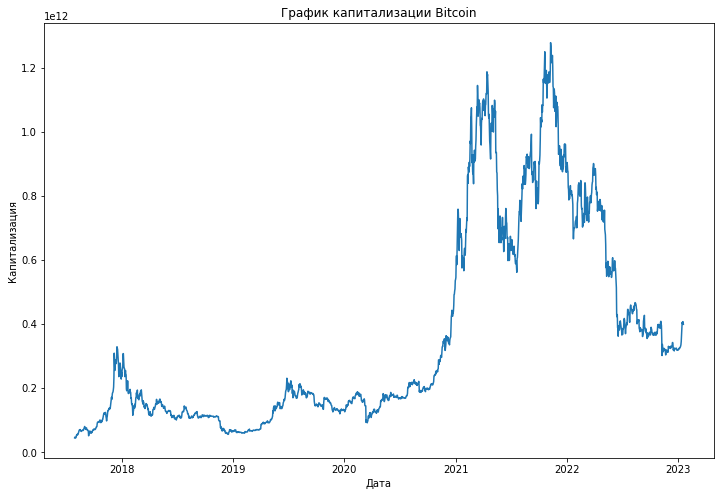

In [13]:
# Создаем график
fig, ax = plt.subplots(figsize=(12, 8))

# Строим линейный график
ax.plot(data_btc["Date"][-2000:], data_btc["MC"][-2000:])

# Настраиваем оси и заголовок графика
ax.set_xlabel('Дата')
ax.set_ylabel('Капитализация')
ax.set_title('График капитализации Bitcoin')

# Показываем график
plt.show()

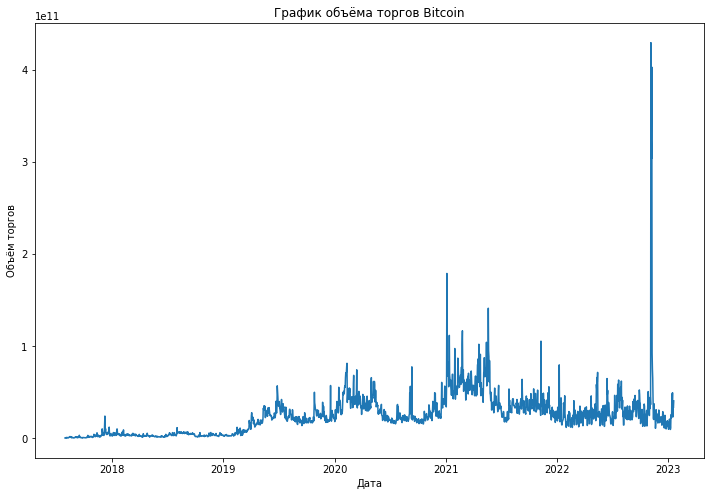

In [14]:
# Создаем график
fig, ax = plt.subplots(figsize=(12, 8))

# Строим линейный график
ax.plot(data_btc["Date"][-2000:], data_btc["Volume"][-2000:])

# Настраиваем оси и заголовок графика
ax.set_xlabel('Дата')
ax.set_ylabel('Объём торгов')
ax.set_title('График объёма торгов Bitcoin')

# Показываем график
plt.show()

In [15]:
for i in l:
    #i["Volume change"] = i['Volume'].pct_change()
    i["Volume"] = i['Volume'].pct_change()
    i["MC change"] = i['MC'].pct_change()

    #i.drop("Volume", axis=1, inplace=True)
    i.drop('MC', axis=1, inplace=True)

In [16]:
data_btc.set_index('Date', inplace=True)
data_btc["MC change"] = data_btc["MC change"].shift(1)
data_btc = data_btc[2:]

data_eth.set_index('Date', inplace=True)
data_eth["MC change"] = data_eth["MC change"].shift(1)
data_eth = data_eth[2:]

data_bnb.set_index('Date', inplace=True)
data_bnb["MC change"] = data_bnb["MC change"].shift(1)
data_bnb = data_bnb[2:]

data_xrp.set_index('Date', inplace=True)
data_xrp["MC change"] = data_xrp["MC change"].shift(1)
data_xrp = data_xrp[2:]

data_ada.set_index('Date', inplace=True)
data_ada["MC change"] = data_ada["MC change"].shift(1)
data_ada = data_ada[2:]

data_matic.set_index('Date', inplace=True)
data_matic["MC change"] = data_matic["MC change"].shift(1)
data_matic = data_matic[2:]

data_sol.set_index('Date', inplace=True)
data_sol["MC change"] = data_sol["MC change"].shift(1)
data_sol = data_sol[2:]

data_dot.set_index('Date', inplace=True)
data_dot["MC change"] = data_dot["MC change"].shift(1)
data_dot = data_dot[2:]

data_ltc.set_index('Date', inplace=True)
data_ltc["MC change"] = data_ltc["MC change"].shift(1)
data_ltc = data_ltc[2:]

data_trx.set_index('Date', inplace=True)
data_trx["MC change"] = data_trx["MC change"].shift(1)
data_trx = data_trx[2:]

data_uni.set_index('Date', inplace=True)
data_uni["MC change"] = data_uni["MC change"].shift(1)
data_uni = data_uni[2:]

data_mkr.set_index('Date', inplace=True)
data_mkr["MC change"] = data_mkr["MC change"].shift(1)
data_mkr = data_mkr[2:]

data_aave.set_index('Date', inplace=True)
data_aave["MC change"] = data_aave["MC change"].shift(1)
data_aave = data_aave[2:]

data_crv.set_index('Date', inplace=True)
data_crv["MC change"] = data_crv["MC change"].shift(1)
data_crv = data_crv[2:]

data_cake.set_index('Date', inplace=True)
data_cake["MC change"] = data_cake["MC change"].shift(1)
data_cake = data_cake[2:]

data_snx.set_index('Date', inplace=True)
data_snx["MC change"] = data_snx["MC change"].shift(1)
data_snx = data_snx[2:]

data_1inch.set_index('Date', inplace=True)
data_1inch["MC change"] = data_1inch["MC change"].shift(1)
data_1inch = data_1inch[2:]

data_cvx.set_index('Date', inplace=True)
data_cvx["MC change"] = data_cvx["MC change"].shift(1)
data_cvx = data_cvx[2:]

data_bal.set_index('Date', inplace=True)
data_bal["MC change"] = data_bal["MC change"].shift(1)
data_bal = data_bal[2:]

data_comp.set_index('Date', inplace=True)
data_comp["MC change"] = data_comp["MC change"].shift(1)
data_comp = data_comp[2:]

In [17]:
data_comp = data_comp[5:]
data_dot = data_dot[5:]
data_crv = data_crv[1:]
data_cake = data_cake[22:]

In [18]:
data_cake

,Volume,MC change
Date,,
2020-10-23,-0.208042,-0.042203
2020-10-24,0.334687,0.097042
2020-10-25,-0.323763,0.107774
2020-10-26,0.492003,-0.068989
2020-10-27,0.900142,-0.160894
...,...,...
2023-01-15,1.749138,0.057009
2023-01-16,-0.607706,0.051791
2023-01-17,0.565791,-0.013937


## Google Trends  ##

In [19]:
gt_bitcoin = pd.read_csv('bitcoin gt.csv') 
gt_crypto = pd.read_csv('crypto gt.csv')
gt_defi = pd.read_csv('defi gt.csv')
gt_dogecoin = pd.read_csv('dogecoin gt.csv')
gt_ethereum = pd.read_csv('ethereum gt.csv')
gt_nft = pd.read_csv('nft gt.csv')

In [20]:
gts = [gt_bitcoin, gt_crypto, gt_defi, gt_dogecoin, gt_ethereum, gt_nft]
for i in gts:
    i_cols = i.columns
    i[i_cols[1]] = i[i_cols[1]].replace("<1", 0)
    i[i_cols[1]] = i[i_cols[1]].astype(float)
    i.rename(columns = {i_cols[0]:'Date', i_cols[1]: 'gt ' + i_cols[1].split(':')[0]}, inplace = True)
    i.Date = pd.to_datetime(i.Date)
    i.set_index('Date', inplace = True)

In [21]:
df_trends = gt_bitcoin.join(gt_crypto, how='outer').join(gt_defi, how='outer').join(gt_dogecoin, how='outer').join(gt_ethereum, how='outer').join(gt_nft, how='outer')

idxgt = pd.date_range(start=df_trends.index.min(), end=df_trends.index.max(), freq='D')
new_gt = pd.DataFrame(index=idxgt)
df_trends = pd.concat([df_trends, new_gt], axis=1)
df_trends = df_trends.interpolate(method='time')
df_trends['gt bitcoin'] = df_trends['gt bitcoin'].fillna(df_trends['gt bitcoin'].rolling(2, min_periods=1).mean())
df_trends['gt crypto'] = df_trends['gt crypto'].fillna(df_trends['gt crypto'].rolling(2, min_periods=1).mean())
df_trends['gt defi'] = df_trends['gt defi'].fillna(df_trends['gt defi'].rolling(2, min_periods=1).mean())
df_trends['gt dogecoin'] = df_trends['gt dogecoin'].fillna(df_trends['gt dogecoin'].rolling(2, min_periods=1).mean())
df_trends['gt ethereum'] = df_trends['gt ethereum'].fillna(df_trends['gt ethereum'].rolling(2, min_periods=1).mean())
df_trends['gt nft'] = df_trends['gt nft'].fillna(df_trends['gt nft'].rolling(2, min_periods=1).mean())

In [22]:
mean_values = df_trends.mean(axis=1)
df_goog_trend = pd.DataFrame({'GT': mean_values})

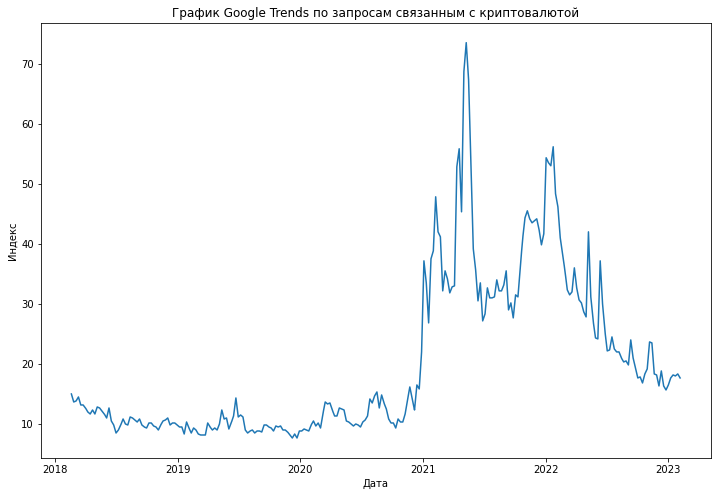

In [23]:
# Создаем график
fig, ax = plt.subplots(figsize=(12, 8))

# Строим линейный график
ax.plot(df_goog_trend["GT"])

# Настраиваем оси и заголовок графика
ax.set_xlabel('Дата')
ax.set_ylabel('Индекс')
ax.set_title('График Google Trends по запросам связанным с криптовалютой')

# Показываем график
plt.show()

In [24]:
#df_goog_trend["GT change"] = df_goog_trend["GT"].pct_change()

#df_goog_trend.drop("GT", axis=1, inplace=True)

df_goog_trend["GT"] = df_goog_trend["GT"].pct_change()

df_goog_trend = df_goog_trend[1:]

## Twitter data ##

In [25]:
df_ensamble = pd.read_excel('output_lstm.xlsx')
df_ensamble.drop('text', axis=1, inplace=True)
df_ensamble.drop('tweet', axis=1, inplace=True)

medians = df_ensamble.groupby('username')[['nlikes', 'nreplies', 'nretweets']].median()
medians = medians.add_suffix('_median')

# Объединяем медианные значения с исходной таблицей
df_ensamble = df_ensamble.join(medians, on='username')

df_ensamble = df_ensamble.sort_values('date', ascending=True)
df_ensamble

,date,username,nlikes,nreplies,nretweets,sentiment,nlikes_median,nreplies_median,nretweets_median
10757,2019-01-02,CryptoHayes,771,21,104,-1,631.0,66.0,53.0
11885,2019-01-04,bgarlinghouse,1212,134,345,0,2555.0,143.0,504.0
154,2019-01-08,matthuang,27,1,2,1,92.5,6.0,7.0
11884,2019-01-08,bgarlinghouse,4007,235,1523,0,2555.0,143.0,504.0
12696,2019-01-08,gavofyork,262,8,24,-1,568.0,56.0,81.0
...,...,...,...,...,...,...,...,...,...
12660,2023-01-31,IOHK_Charles,822,94,36,1,354.5,24.0,36.0
12661,2023-01-31,IOHK_Charles,543,25,43,0,354.5,24.0,36.0
9818,2023-01-31,justinsuntron,296,92,61,1,422.0,61.0,111.0
5839,2023-01-31,brian_armstrong,92,13,4,1,377.5,76.5,34.0


divider = 0.2
df_ensamble['value'] = (df_ensamble['sentiment'] * (df_ensamble['nlikes']/df_ensamble['nlikes_median'])**(divider) *
                     (df_ensamble['nreplies']/df_ensamble['nreplies_median'])**(divider)
                     * (df_ensamble['nretweets']/df_ensamble['nretweets_median'])**(divider))

t1 = ["AndreCronjeTech", "alive_eth", "CryptoCred", "christyhwchoi", "FatManTerra", "Rewkang", "shaunmmaguire", "FEhrsam"]
t2 = ['EvgenyGaevoy', 'brian_armstrong', 'hasufl', 'CryptoHayes', 'aeyakovenko', 'saylor',
       'matthuang', 'TusharJain_', 'andrew__reed', 'sandeepnailwal',
       'el33th4xor', 'ashwathbk', 'justinsuntron', 'lyu_johnny', 'anildelphi',
       'cz_binance', 'AlamedaTrabucco', 'bgarlinghouse', 'MapleLeafCap',
       'Darrenlautf', 'zhusu', 'FrankResearcher', 'ilblackdragon',
       'stablekwon', 'Alfred_Lin', 'ysiu', 'jaekwon', 'SpartanBlack_1',
       'AriannaSimpson', 'IOHK_Charles', 'gavofyork']
t3 = ["twobitidiot", "ummjackson","KyleLDavies", "accel_capital", "KyleSamani", "Kevin_Kelly_II", "SBF_FTX", "VitalikButerin",
     "pierskicks", "tomhschmidt", "fintechfrank", ]

coeff = 1.5
def adjusting(row):
    if row['username'] in t1:
        return row['value'] * coeff
    if row['username'] in t2:
        return row['value'] / coeff
    if row['username'] in t3:
        return row['value'] * (-coeff)

# применяем функцию к столбцу "value"
df_ensamble['value'] = df_ensamble.apply(adjusting, axis=1)

In [29]:
# Группируем по столбцу "date" и вычисляем среднее значение столбца "value" в каждой группе
df_mean_ensamble = df_ensamble.groupby('date')['value'].mean().reset_index().sort_values('date')
df_mean_ensamble = df_mean_ensamble.rename(columns={'date': 'Date'})
df_mean_ensamble = df_mean_ensamble.rename(columns={'value': 'Sentiment'})

df_mean_ensamble

,Date,Sentiment
0,2019-01-02,-0.631539
1,2019-01-04,0.000000
2,2019-01-08,-0.006645
3,2019-01-11,0.000000
4,2019-01-14,0.919721
...,...,...
1294,2023-01-27,1.254850
1295,2023-01-28,-0.865198
1296,2023-01-29,0.866896
1297,2023-01-30,0.702590


In [30]:
df_mean_ensamble.set_index('Date', inplace=True)

idxe = pd.date_range(start=df_mean_ensamble.index.min(), end=df_mean_ensamble.index.max(), freq='D')
new_ens = pd.DataFrame(index=idxe)
df_mean_ensamble = pd.concat([df_mean_ensamble, new_ens], axis=1)
df_mean_ensamble = df_mean_ensamble.interpolate(method='time')
df_mean_ensamble['Sentiment'] = df_mean_ensamble['Sentiment'].fillna(df_mean_ensamble['Sentiment'].rolling(2, min_periods=1).mean())
df_mean_ensamble

,Sentiment
2019-01-02,-0.631539
2019-01-03,-0.315770
2019-01-04,0.000000
2019-01-05,-0.001661
2019-01-06,-0.003323
...,...
2023-01-27,1.254850
2023-01-28,-0.865198
2023-01-29,0.866896
2023-01-30,0.702590


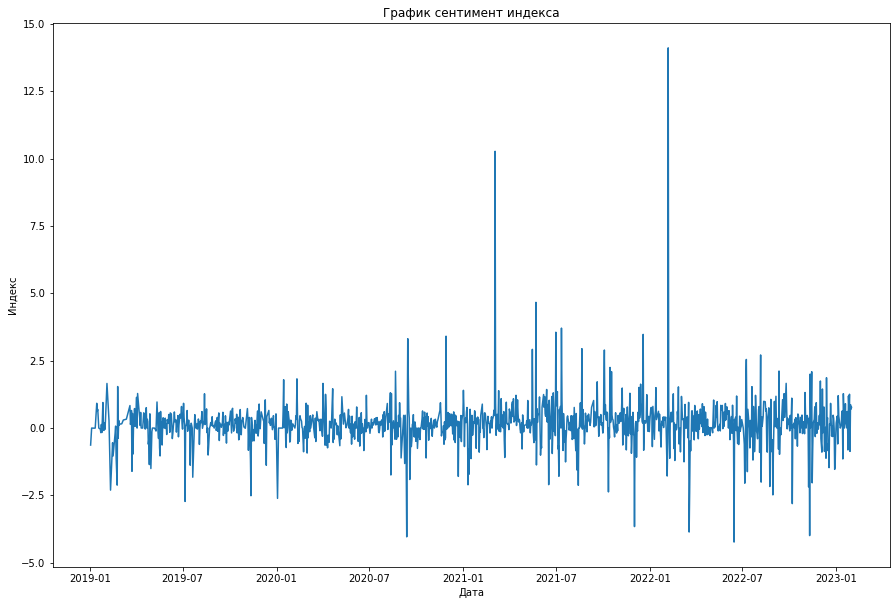

In [31]:
# Создаем график
fig, ax = plt.subplots(figsize=(15, 10))

# Строим линейный график
ax.plot(df_mean_ensamble['Sentiment'])

# Настраиваем оси и заголовок графика
ax.set_xlabel('Дата')
ax.set_ylabel('Индекс')
ax.set_title('График сентимент индекса')

# Показываем график
plt.show()

## Объединим датасеты ##

In [32]:
df = df_mean_ensamble.join(df_fg, how='outer').join(df_vix, how='outer').join(df_goog_trend, how='outer')
df = df.dropna()
df

,Sentiment,FG,VIX,GT
2019-01-02,-0.631539,0.250000,-0.045230,-0.004890
2019-01-03,-0.315770,0.100000,0.096038,-0.004914
2019-01-04,0.000000,0.454545,-0.159921,-0.004938
2019-01-05,-0.001661,-0.250000,0.000312,-0.004963
2019-01-06,-0.003323,-0.138889,0.000312,-0.004988
...,...,...,...,...
2023-01-27,1.254850,0.018519,-0.011746,0.002618
2023-01-28,-0.865198,-0.054545,0.025752,0.002611
2023-01-29,0.866896,0.057692,0.025105,0.002604
2023-01-30,0.702590,0.109091,0.024490,-0.005195


Биткоин тест

In [33]:
btc_df = df.join(data_btc, how='outer')
btc_df = btc_df.dropna()
btc_df

,Sentiment,FG,VIX,GT,Volume,MC change
2019-01-02,-0.631539,0.250000,-0.045230,-0.004890,-0.100805,-0.031154
2019-01-03,-0.315770,0.100000,0.096038,-0.004914,0.213241,0.027410
2019-01-04,0.000000,0.454545,-0.159921,-0.004938,-0.307118,0.021981
2019-01-05,-0.001661,-0.250000,0.000312,-0.004963,0.304641,-0.025443
2019-01-06,-0.003323,-0.138889,0.000312,-0.004988,-0.063125,0.011051
...,...,...,...,...,...,...
2023-01-15,1.276418,0.130435,0.020288,0.003947,0.252675,0.053096
2023-01-16,0.638209,-0.134615,0.019885,-0.001311,-0.533884,0.058887
2023-01-17,0.000000,0.133333,-0.006670,-0.001312,0.508720,-0.008668
2023-01-18,0.113133,0.019608,0.050620,-0.001314,-0.043969,0.015093


In [34]:
X = btc_df.drop('MC change', axis=1)
y = btc_df['MC change']

Тест на стационарность рядов

In [35]:
colus = list(btc_df.columns)

for i in colus: 
    # применяем ADF-тест
    result = adfuller(btc_df[i])

    # выводим результаты теста
    print(str(i)+ ":")
    print('p-value:', round(result[1], 3), "\n")

Sentiment:
p-value: 0.0 

FG:
p-value: 0.0 

VIX:
p-value: 0.0 

GT:
p-value: 0.0 

Volume:
p-value: 0.0 

MC change:
p-value: 0.0 



Тест на мультиколинеарность

In [36]:
vif = pd.DataFrame()
vif["Features"] = btc_df.columns
vif["VIF Factor"] = [variance_inflation_factor(btc_df.values, i) for i in range(btc_df.shape[1])]

# вывод результатов
vif

,Features,VIF Factor
0,Sentiment,1.007281
1,FG,1.019181
2,VIX,1.008951
3,GT,1.007229
4,Volume,1.003224
5,MC change,1.021108


In [37]:
# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)

Модель посложнее

In [38]:
# Создаем модель ARIMA

model_t = pm.auto_arima(y, exogenous=X_scaled, start_p=1, max_p=5, start_q=1, max_q=5, start_d = 0, max_d=1, seasonal=False,
                     trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, scoring='mse')

# Выводим информацию о подобранных параметрах модели
model_t.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5546.438, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5546.191, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5547.110, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5546.936, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-5546.441, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5544.604, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5549.484, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5548.177, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5548.573, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5548.669, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5549.304, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5546.603, Time=0.15 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.745 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1479
Model:               SARIMAX(1, 0, 0)   Log Likelihood                2777.742
Date:                Thu, 11 May 2023   AIC                          -5549.484
Time:                        00:05:28   BIC                          -5533.587
Sample:                    01-02-2019   HQIC                         -5543.558
                         - 01-19-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.001      2.065      0.039       0.000       0.004
ar.L1         -0.0473      0.022     -2.186      0.029      -0.090      -0.005
sigma2         0.0014    2.2e-05     62.094      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4616.96
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
model = sm.tsa.ARIMA(y, exog=X_scaled, order=(1, 0, 0), trend='n')
results = model.fit()

# Выводим значимые переменные
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              MC change   No. Observations:                 1479
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2791.491
Date:                Thu, 11 May 2023   AIC                          -5566.982
Time:                        00:05:28   BIC                          -5524.589
Sample:                    01-02-2019   HQIC                         -5551.178
                         - 01-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.956      0.050   -3.99e-06       0.004
x1             0.0022      0.001      3.232      0.001       0.001       0.003
x2            -0.0038      0.001     -4.100      0.0

In [40]:
# Вычисление остатков модели
residuals = results.resid

# Тестирование на гетероскедастичность
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, exog_het=X)

print('Chi-squared statistic: {:.2f}'.format(bp_test[0]))
print('p-value: {:.4f}'.format(bp_test[1]))

Chi-squared statistic: 12.82
p-value: 0.0122


In [41]:
dw_test = sm.stats.stattools.durbin_watson(results.resid)
print(dw_test)

2.0032670248476525


Объединим

In [ ]:
data_btc, data_eth, data_bnb, data_xrp, data_ada, data_mati, data_dot, data_ltc, data_trx,
data_uni, data_mkr, data_aave, data_crv, data_cake, data_snx, data_1inch, data_cvx, data_bal, data_comp

In [85]:
dft = df.join(data_comp, how='outer')
dft = dft.dropna()
X = dft.drop('MC change', axis=1)
y = dft['MC change']
# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)

In [86]:
dft.to_excel('data_comp.xlsx', index=False)

In [613]:
# Создаем модель ARIMA

model_t = pm.auto_arima(y, exogenous=X_scaled, start_p=1, max_p=5, start_q=1, max_q=5, d = 0, seasonal=False,
                     trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, scoring='mse')

# Выводим информацию о подобранных параметрах модели
model_t.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2740.606, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2731.854, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2731.326, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2731.105, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2740.690, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-2740.117, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-2738.720, Time=0.59 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-2745.927, Time=0.78 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2740.806, Time=0.29 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.85 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-2743.792, Time=0.84 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-2734.508, Time=0.22 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-2748.576, Time=0.93 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-2759.021, Time=1.01 sec
 ARIMA(4,0,2)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1362
Model:               SARIMAX(4, 0, 3)   Log Likelihood                1392.178
Date:                Tue, 09 May 2023   AIC                          -2766.356
Time:                        20:21:55   BIC                          -2719.406
Sample:                    04-29-2019   HQIC                         -2748.781
                         - 01-19-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0252      0.010      2.547      0.011       0.006       0.045
ar.L1         -1.1877      0.112    -10.600      0.000      -1.407      -0.968
ar.L2         -0.7770      0.176     -4.414      0.000      -1.122      -0.432
ar.L3         -0.1200      0.114     -1.050      0.294      -0.344       0.104
ar.L4          0.1558      0.021      7.587      0.000       0.116       0.196
ma.L1          1.2201      0.117     10.449      0.000       0.991       1.449
ma.L2          0.8905      0.184      4.853      0.000       0.531       1.250
ma.L3          0.2636      0.120      2.202      0.028       0.029       0.498
sigma2         0.0076      0.000     49.337      0.000       0.007       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7438.88
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [615]:
model = sm.tsa.ARIMA(y, exog=X_scaled, order=(4, 0, 4), trend='n')
results = model.fit()
#results = model.fit(cov_type = "robust")

# Выводим значимые переменные
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              MC change   No. Observations:                 1362
Model:                 ARIMA(4, 0, 4)   Log Likelihood                1397.578
Date:                Tue, 09 May 2023   AIC                          -2765.156
Time:                        20:22:06   BIC                          -2686.905
Sample:                    04-29-2019   HQIC                         -2735.864
                         - 01-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.003      2.757      0.006       0.002       0.015
x1             0.0022      0.002      0.991      0.322      -0.002       0.007
x2            -0.0061      0.002     -2.623      0.0

In [616]:
# Вычисление остатков модели
residuals = results.resid

# Тестирование на гетероскедастичность
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, exog_het=X)

print('Chi-squared statistic: {:.2f}'.format(bp_test[0]))
print('p-value: {:.3f}'.format(bp_test[1]))

Chi-squared statistic: 13.80
p-value: 0.008


In [617]:
dw_test = sm.stats.stattools.durbin_watson(results.resid)
print(round(dw_test, 3))

1.999


TVL

In [618]:
dft = df.join(df_tvl, how='outer')
dft = dft.dropna()
X = dft.drop('TVL change', axis=1)
y = dft['TVL change']
# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)

In [619]:
# Создаем модель ARIMA

model_t = pm.auto_arima(y, exogenous=X_scaled, start_p=1, max_p=5, start_q=1, max_q=5, d = 0, seasonal=False,
                     trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, scoring='mse')

# Выводим информацию о подобранных параметрах модели
model_t.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3768.709, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3691.505, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3770.511, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3763.733, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3768.757, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3766.915, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3777.210, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3694.919, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-3775.286, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3775.274, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3770.943, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3773.364, Time=0.45 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.934 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1479
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1891.605
Date:                Tue, 09 May 2023   AIC                          -3777.210
Time:                        20:23:20   BIC                          -3761.313
Sample:                    01-02-2019   HQIC                         -3771.284
                         - 01-19-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0052      0.002      2.552      0.011       0.001       0.009
ar.L1         -0.2354      0.010    -24.107      0.000      -0.255      -0.216
sigma2         0.0045   4.05e-05    112.033      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            120174.24
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             3.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [620]:
model = sm.tsa.ARIMA(y, exog=X_scaled, order=(1, 0, 0), trend='n')
results = model.fit()
#results = model.fit(cov_type = "robust")

# Выводим значимые переменные
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             TVL change   No. Observations:                 1479
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1910.557
Date:                Tue, 09 May 2023   AIC                          -3807.114
Time:                        20:23:36   BIC                          -3770.020
Sample:                    01-02-2019   HQIC                         -3793.285
                         - 01-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      2.521      0.012       0.001       0.007
x1            -0.0037      0.001     -2.740      0.006      -0.006      -0.001
x2             0.0100      0.001      9.861      0.0

In [621]:
# Вычисление остатков модели
residuals = results.resid

# Тестирование на гетероскедастичность
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, exog_het=X)

print('Chi-squared statistic: {:.2f}'.format(bp_test[0]))
print('p-value: {:.3f}'.format(bp_test[1]))

Chi-squared statistic: 6.56
p-value: 0.087


In [622]:
dw_test = sm.stats.stattools.durbin_watson(results.resid)
print(round(dw_test, 3))

1.994
